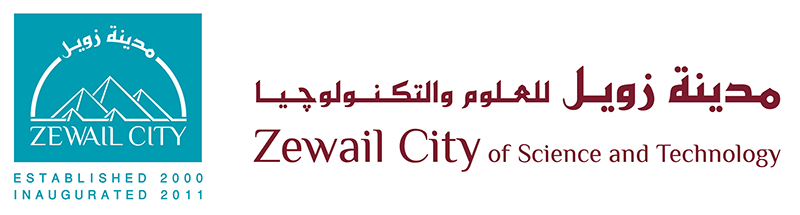

# <center><b>Books Recommendation System</b></center>



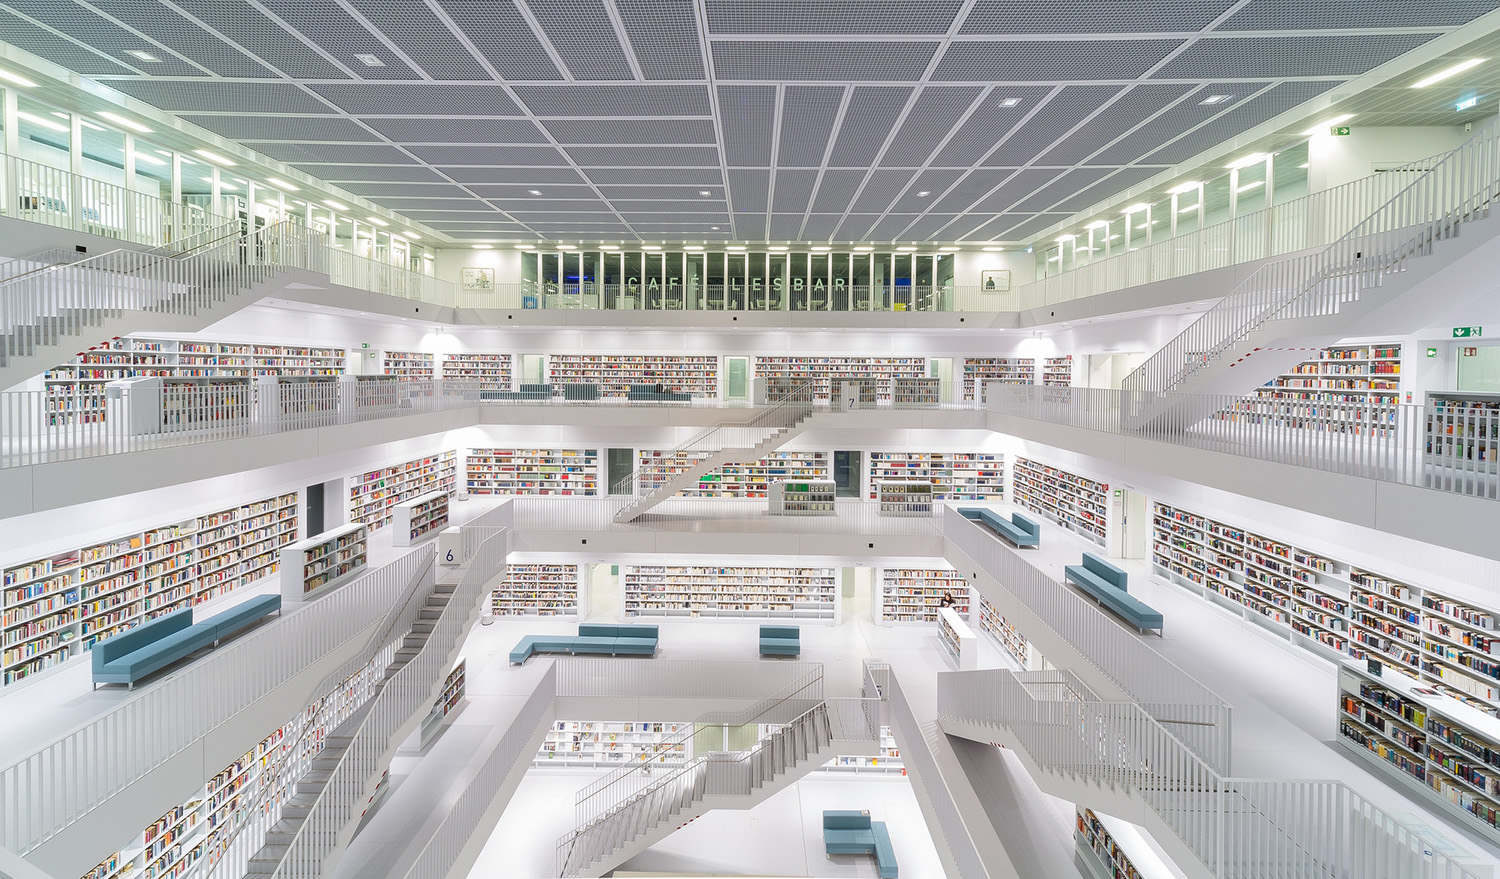

<center><b>CIE 427</b></center>

<center><b>Mariam Elseedawy---201901281</b></center>
<center><b>Rodina Mohamed--------201900642</b></center>
<center><b>Shrouk Shata----------201902199</b></center>
<center><b>Verina Zarif------------201901451</b></center>

<center><b>Dr. Mohamed Khamis</b></center>
<center><b>Eng. Aya Elghaysh</b></center>


<center>Communications and Information Engineering</center>
<center>University of Science and Technology</center>
<center>Zewail City</center>

---

# Introduction

A book recommendation system is a software or algorithm that suggests books to users based on their preferences, behavior, or other relevant data. Its goal is to assist users in discovering new books they might be interested in, enhancing their overall reading experience. There are various types of recommendation systems, and they employ different techniques to generate personalized suggestions.

# Implementation

## Setting up



In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=2c25bf44c17fba2586e76365575a6a46c6f53b747a31f5a9920434b427a3a577
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
# Import PySpark and initialize
from pyspark.sql import SparkSession

In [ ]:
from pyspark.sql.functions import col

In [ ]:
from pyspark.sql.functions import sum

In [ ]:
from pyspark.sql.functions import count, isnan, when

In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
from pyspark.ml import Pipeline

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder

In [ ]:
from pyspark.ml.tuning import CrossValidator

In [ ]:
from pyspark.ml.recommendation import ALSModel

In [ ]:
from pyspark.sql.functions import col, sum as spark_sum

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

## Initializing Spark Session

In [ ]:
# Create a Spark Session
spark = SparkSession.builder \
    .appName("Book Recommendation") \
    .getOrCreate()

## Getting the Dataset

https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset/


The dataset is splitted into 3 files as follows:
1. **Books** : Books are identified by their respective `ISBN`. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given `(Book-Title, Book-Author, Year-Of-Publication, Publisher)`, obtained from Amazon Web.URLs linking to cover images are also given, appearing in three different flavours `(Image-URL-S, Image-URL-M, Image-URL-L)`.

2. **Users**: Represents the users. Note that user IDs `(User-ID)` have been anonymized and map to integers. Demographic data is provided `(Location, Age)` if available. Otherwise, these fields contain NULL-values.

3. **Ratings**: represnts the book rating information. Ratings `(Book-Rating)` are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0 which means that user didn't say his/her opinion.

In [ ]:
# Load the Ratings data
ratings_df = spark.read.csv("Ratings.csv", header=True, inferSchema=True)

In [ ]:
# Print the schema of the dataset
ratings_df.printSchema()

root
 |-- User-ID: integer (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- Book-Rating: integer (nullable = true)



In [ ]:
# Load the Books data if needed
books_df = spark.read.csv("Books.csv", header=True, inferSchema=True)

In [ ]:
# Print the schema of the dataset
books_df.printSchema()

root
 |-- ISBN: string (nullable = true)
 |-- Book-Title: string (nullable = true)
 |-- Book-Author: string (nullable = true)
 |-- Year-Of-Publication: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Image-URL-S: string (nullable = true)
 |-- Image-URL-M: string (nullable = true)
 |-- Image-URL-L: string (nullable = true)



In [ ]:
# Load the Users data
users_df = spark.read.csv("Users.csv", header=True, inferSchema=True)

In [ ]:
# Print the schema of the dataset
users_df.printSchema()

root
 |-- User-ID: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: string (nullable = true)



## Preprocessing

### Handling Missing Values

In [ ]:
# Iterate through columns and get the count of null values in each column
null_counts = books_df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in books_df.columns]).show()

+----+----------+-----------+-------------------+---------+-----------+-----------+-----------+
|ISBN|Book-Title|Book-Author|Year-Of-Publication|Publisher|Image-URL-S|Image-URL-M|Image-URL-L|
+----+----------+-----------+-------------------+---------+-----------+-----------+-----------+
|   0|         0|          1|                  0|        2|          0|          0|          3|
+----+----------+-----------+-------------------+---------+-----------+-----------+-----------+



In [ ]:
# Drop rows with any null value in any column
books_df = books_df.dropna()

In [ ]:
# Iterate through columns and get the count of null values in each column
null_counts = books_df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in books_df.columns]).show()

+----+----------+-----------+-------------------+---------+-----------+-----------+-----------+
|ISBN|Book-Title|Book-Author|Year-Of-Publication|Publisher|Image-URL-S|Image-URL-M|Image-URL-L|
+----+----------+-----------+-------------------+---------+-----------+-----------+-----------+
|   0|         0|          0|                  0|        0|          0|          0|          0|
+----+----------+-----------+-------------------+---------+-----------+-----------+-----------+



In [ ]:
# Iterate through columns and get the count of null values in each column
null_counts = users_df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in users_df.columns]).show()

+-------+--------+------+
|User-ID|Location|   Age|
+-------+--------+------+
|      1|       0|110518|
+-------+--------+------+



In [ ]:
users_df = users_df.na.drop(subset=["User-ID"])

Because the column age contains many null values and is an important column, we could replace null values with the median of the age calculated from non null cells.

In [ ]:
from pyspark.sql.functions import when

# Calculate median age
median_age = users_df.approxQuantile("Age", [0.5], 0.01)[0]

# Fill null values in 'Age' column with median age
users_df = users_df.withColumn('Age', when(col('Age').isNull(), median_age).otherwise(col('Age')))


In [ ]:
# Iterate through columns and get the count of null values in each column
null_counts = ratings_df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in ratings_df.columns]).show()

+-------+----+-----------+
|User-ID|ISBN|Book-Rating|
+-------+----+-----------+
|      0|   0|          0|
+-------+----+-----------+



In [ ]:
ratings_df = ratings_df.na.drop()

The data type of the "Year-Of-Publication" column is wrong. It should be int not string so we should correct its type.

In [ ]:
# Convert 'Year-Of-Publication' column to int
books_df = books_df.withColumn('Year-Of-Publication', col('Year-Of-Publication').cast('int'))

### Removing duplicates

In [ ]:
ISBN_num= books_df.select('ISBN').distinct()
print(ISBN_num.count())

In [ ]:
title_num= books_df.select('Book-Title').distinct()
print(title_num.count())

According to the above data, the number of ISBNs exceeds the number of book titles, implying that some ISBNs are used for more than one book title. To avoid bias, this problem must be addressed by transforming the dataset into unique data and remove duplicates.

In [ ]:
#books_df = books_df.dropDuplicates()
#ratings_df = ratings_df.dropDuplicates()
#users_df = users_df.dropDuplicates()

books_df = books_df.dropDuplicates(['ISBN'])

### Removing Unnecessary Columns:

For the books dataframe, Information such as image size is unnecessary because it will not provide useful information about book recommendations, so the 'Image-URL-S', 'Image-URL-M', and 'Image-URL-L' features/columns can be deleted.

In [ ]:
# Dropping unnecessary columns
columns_to_drop = ['Image-URL-S', 'Image-URL-M', 'Image-URL-L']

# Drop the specified columns
books_df = books_df.select([col for col in books_df.columns if col not in columns_to_drop])

### Exploratory Data Analysis

In [ ]:
# Describe the ratings
ratings_df.describe().show()

# Count the number of distinct users and books
print("Unique users:", ratings_df.select("user-id").distinct().count())
print("Unique books:", ratings_df.select("book-rating").distinct().count())


+-------+------------------+-----------+------------------+
|summary|           User-ID|       ISBN|       Book-Rating|
+-------+------------------+-----------+------------------+
|  count|           1149780|    1149780|           1149780|
|   mean|140386.39512602412|   Infinity|2.8669501991685364|
| stddev| 80562.27771851397|        NaN| 3.854183859201633|
|    min|                 2| 0330299891|                 0|
|    max|            278854|  Ô½crosoft|                10|
+-------+------------------+-----------+------------------+

Unique users: 105283
Unique books: 11


### Merging Dataset Files

In [ ]:
# Renaming the 'ISBN' column in one of the DataFrames before the join
books_df = books_df.withColumnRenamed("ISBN", "BookISBN")

In [ ]:
# Join ratings with books
ratings_books_df = ratings_df.join(books_df, ratings_df.ISBN == books_df.BookISBN, "inner")

In [ ]:
# Perform an outer join
merged_df = ratings_books_df.join(users_df, 'User-ID', 'inner')

In [ ]:
merged_df.show(10)

+-------+----------+-----------+----------+--------------------+----------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----+
|User-ID|      ISBN|Book-Rating|  BookISBN|          Book-Title|     Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|            Location| Age|
+-------+----------+-----------+----------+--------------------+----------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----+
|      9|0609804618|          0|0609804618|Our Dumb Century:...|       The Onion|               1999|  Three Rivers Press|http://images.ama...|http://images.ama...|http://images.ama...|germantown, tenne...|NULL|
|      9|0440234743|          0|0440234743|       The Testament|    John Grisham|               1999|                Dell|http://images.ama...|http://im

### Selecting Features for Training:

In [ ]:
final_df = merged_df.selectExpr("`User-ID` as user", "BookISBN as item", "`Book-Rating` as rating")

In [ ]:
final_df.show(10)

+------+----------+------+
|  user|      item|rating|
+------+----------+------+
|276733|2080674722|     0|
|276798|3499134004|     0|
|276798|3548603203|     6|
|276904|0738205737|     5|
|276936|0749317256|     0|
|276964|0515131520|     6|
|277157|0441005470|     0|
|277353|0739417096|     8|
|277375|3548603203|     0|
|277378|0767906373|     0|
+------+----------+------+
only showing top 10 rows



### Converting Data Types
Ensuring that the user and item IDs are integers and the ratings are the desired numeric type (double).

In [ ]:
# Cast 'user' and 'item' columns to integers
final_df = final_df.withColumn("user", col("user").cast("int"))
final_df = final_df.withColumn("item", col("item").cast("int"))

# Cast 'rating' column to a numeric type (e.g., double)
final_df = final_df.withColumn("rating", col("rating").cast("double"))

In [ ]:
# Show the result
final_df.show(10)

+------+----------+------+
|  user|      item|rating|
+------+----------+------+
|276733|2080674722|   0.0|
|276798|      NULL|   0.0|
|276798|      NULL|   6.0|
|276904| 738205737|   5.0|
|276936| 749317256|   0.0|
|276964| 515131520|   6.0|
|277157| 441005470|   0.0|
|277353| 739417096|   8.0|
|277375|      NULL|   0.0|
|277378| 767906373|   0.0|
+------+----------+------+
only showing top 10 rows



### Cleaning Data from Nulls

In [ ]:
# Identifying nulls in the item ID column
null_item_ids = final_df.filter(final_df['item'].isNull()).count()

if null_item_ids > 0:
    print(f"There are {null_item_ids} null item IDs. Consider removing or imputing these records.")

# Removing records with null item IDs
final_df_clean = final_df.filter(final_df['item'].isNotNull())

There are 128774 null item IDs. Consider removing or imputing these records.


In [ ]:
# Removing records with null user IDs if they exist
train_clean = final_df_clean.filter(final_df_clean['user'].isNotNull())

---

### Splitting Dataset

In [ ]:
# Split the data into training and test sets
(train, test) = final_df_clean.randomSplit([0.8, 0.2])

## Data Visualization

In [ ]:
dataset_pd= merged_df.toPandas()

### Books Rating Distribution:

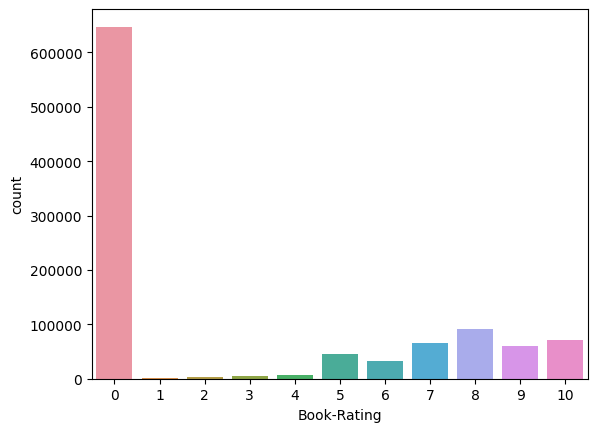

In [ ]:
sns.countplot(x='Book-Rating', data=dataset_pd)
plt.show()

**Comment:**
Implicit feedback data is common in recommendation systems, where users do not explicitly provide ratings but their actions can be used as an indication of preference. In this case, a rating of 0 could indicate a missing or unknown rating, which is frequently interpreted as "implicit negative feedback." It means that users who have not given a book a rating are not necessarily indicating that they dislike it; they may simply not have expressed an opinion about it.

###  Year Of Publication Distribution:

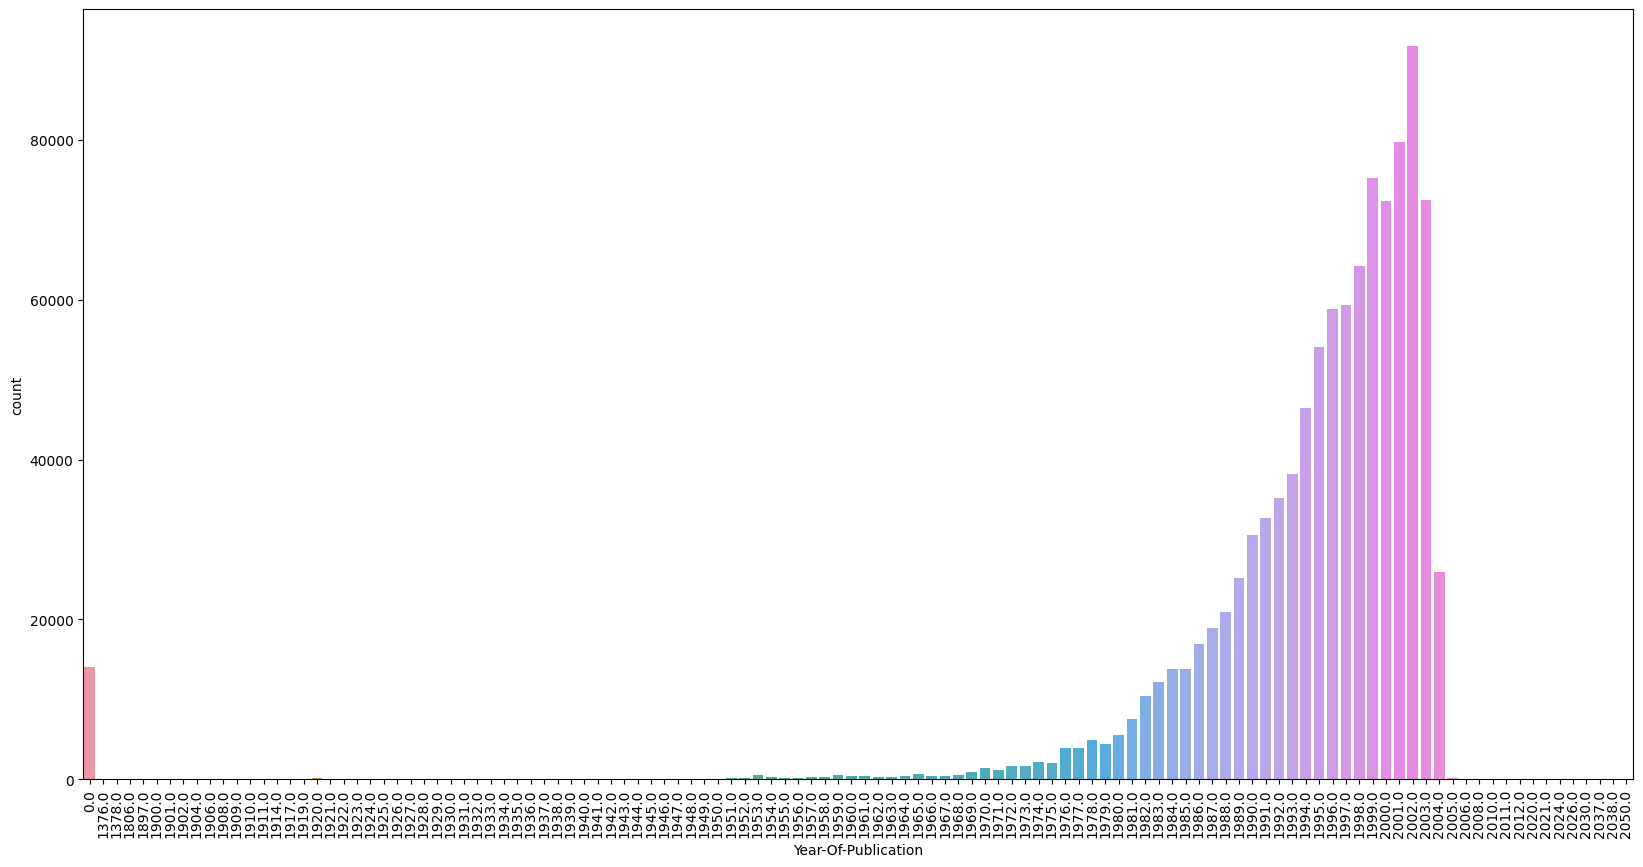

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(x=dataset_pd['Year-Of-Publication']);
plt.xticks(rotation=90)
plt.show()

**Comment:** most books Year-of-Publication is between **1983-2004**

### Let's see the top 20 publishers:

<Axes: >

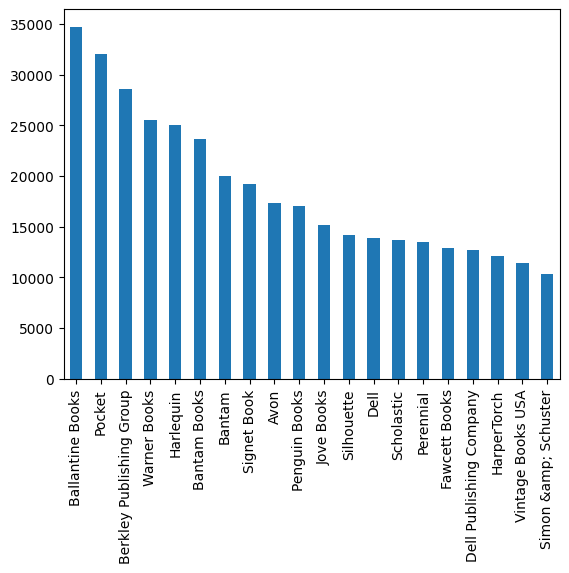

In [ ]:
# top 20 Publishers
dataset_pd['Publisher'].value_counts().head(20).plot(kind='bar')

**Comment:** It is obvious that the "Ballantine Books" publisher is the top one.

### Let's see the top 10 Countries of the Users:

In [ ]:
dataset_pd['Location'] = dataset_pd['Location'].apply(lambda x:x.split(',')[-1])

<Axes: >

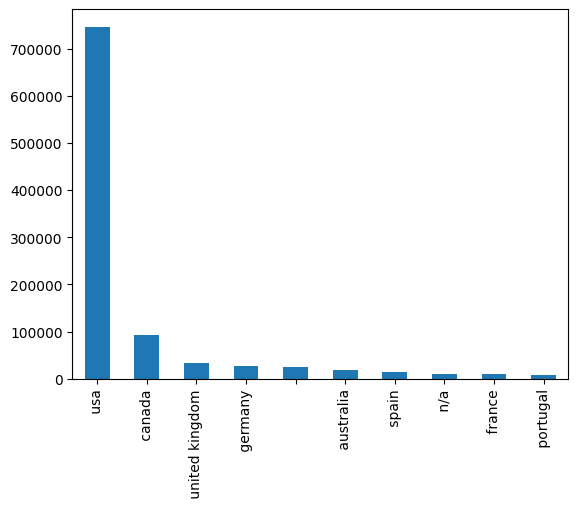

In [ ]:
# top 10 user locations
dataset_pd['Location'].value_counts().head(10).plot(kind='bar')

It is obvious that the location data has some NULL values, but the majority of users are located in the USA.

### Let's see the Books Ratings For the First 20 Years:

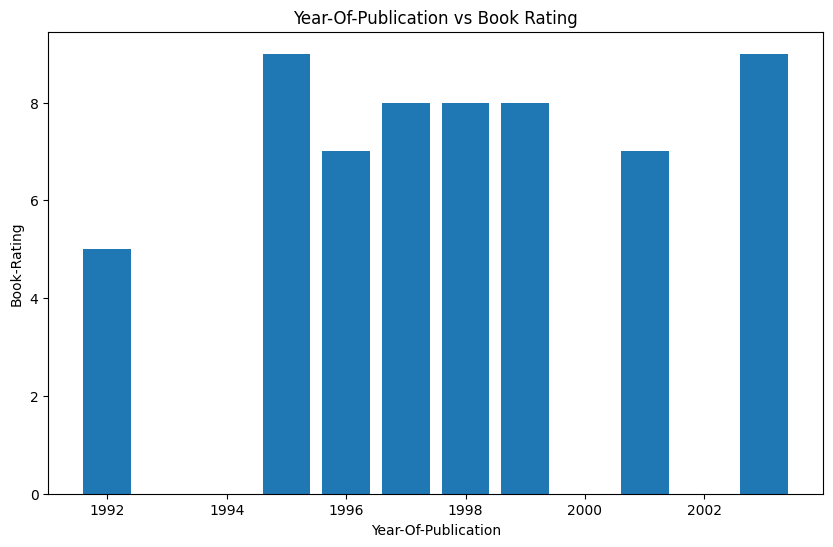

In [ ]:
# Plotting using matplotlib
plt.figure(figsize=(10, 6))
plt.bar(dataset_pd['Year-Of-Publication'].head(20), dataset_pd['Book-Rating'].head(20))
plt.xlabel('Year-Of-Publication')
plt.ylabel('Book-Rating')
plt.title('Year-Of-Publication vs Book Rating')
plt.show()

### Let's see the Most Frequent 10 Years of Publication:

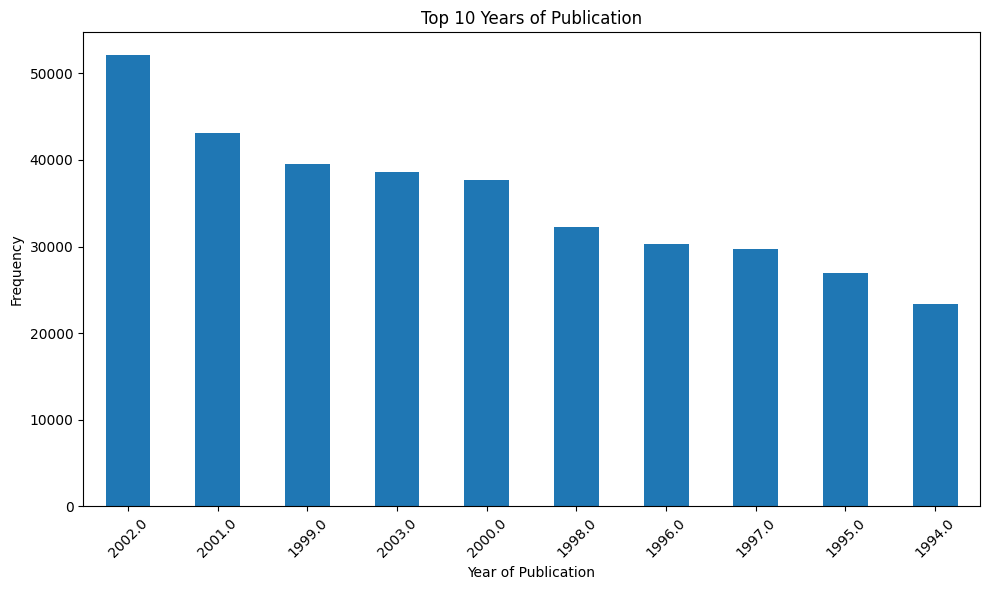

In [ ]:
# Get the value counts for 'Year-Of-Publication' and select the top 10 most frequent years
top_years = dataset_pd['Year-Of-Publication'].value_counts().head(10)

# Plotting using matplotlib
plt.figure(figsize=(10, 6))
top_years.plot(kind='bar')
plt.xlabel('Year of Publication')
plt.ylabel('Frequency')
plt.title('Top 10 Years of Publication')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


### Let's see the Top 20 Rated Books:

<ipython-input-46-d7e3ae0c3931>:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust layout to prevent clipping of labels


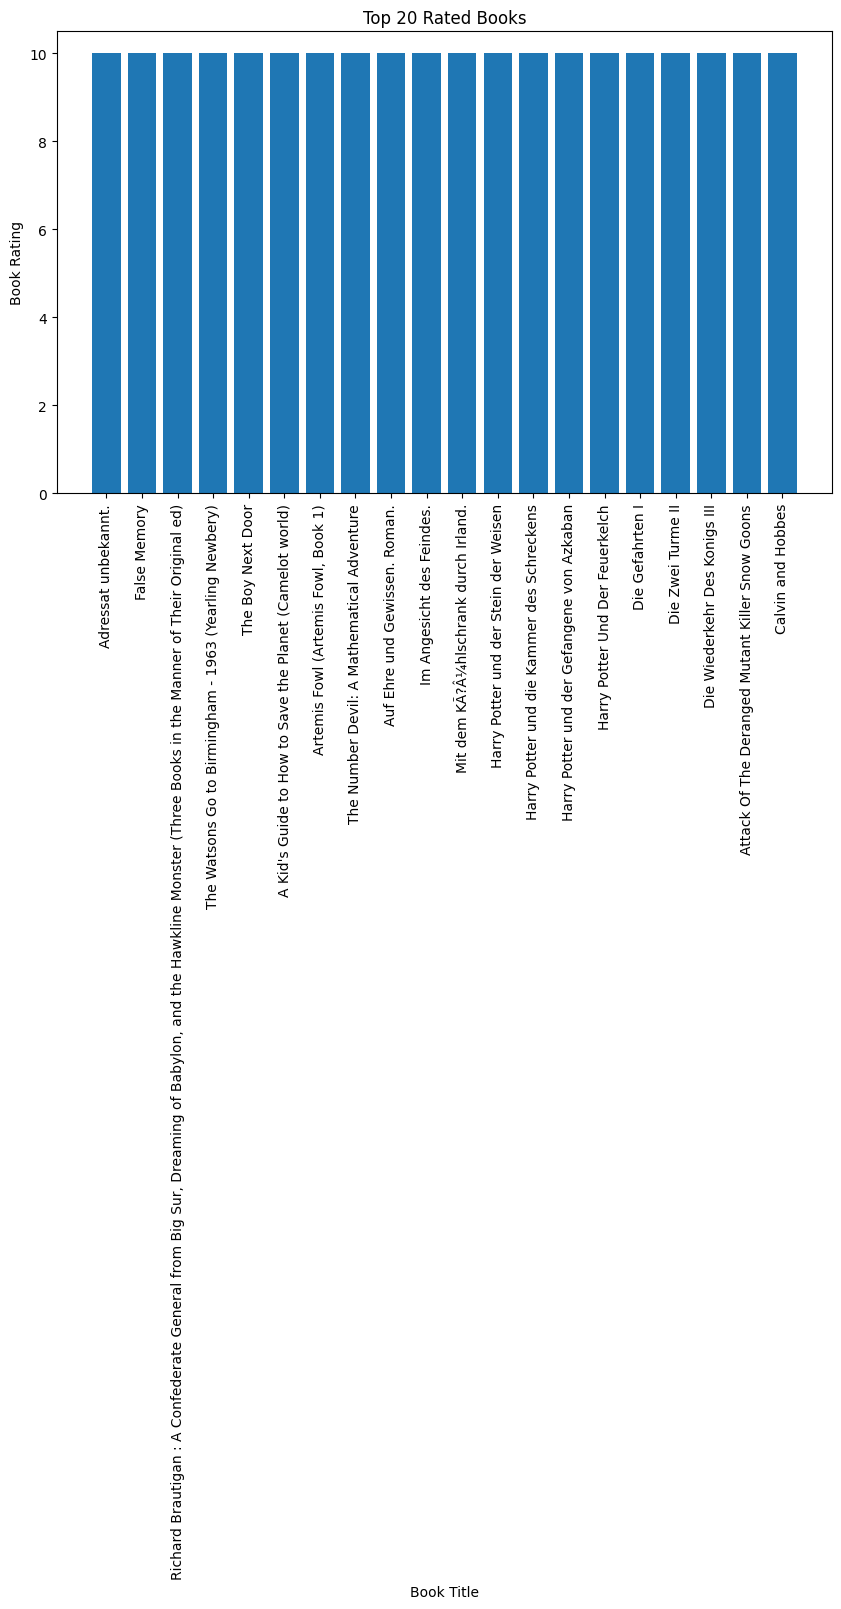

In [ ]:
# Sort the DataFrame by 'Book-Rating' in descending order and select the top 10 rows
top_books = dataset_pd.nlargest(20, 'Book-Rating')

# Plotting using matplotlib
plt.figure(figsize=(10, 6))
plt.bar(top_books['Book-Title'], top_books['Book-Rating'])
plt.xlabel('Book Title')
plt.ylabel('Book Rating')
plt.title('Top 20 Rated Books')
plt.xticks(rotation=90)  # Rotating x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


## Working on the Model

### Building the model

**Collaborative Filtering with ALS:**

Collaborative filtering is a technique used in recommendation systems to make automatic predictions (filtering) about the preferences of a user by collecting preferences from many users (collaborating). ALS is one of the popular collaborative filtering algorithms.

In collaborative filtering, there are two main types:

**1. User-Based Collaborative Filtering:** This approach recommends products to a user that similar users have liked.

**2. Item-Based Collaborative Filtering:** This approach recommends products that are similar to those the user has liked in the past.

ALS falls under the second category, item-based collaborative filtering. It works by decomposing the user-item interaction matrix into two lower-rank matrices, one for users and one for items. The algorithm alternately updates these matrices to minimize the prediction error.

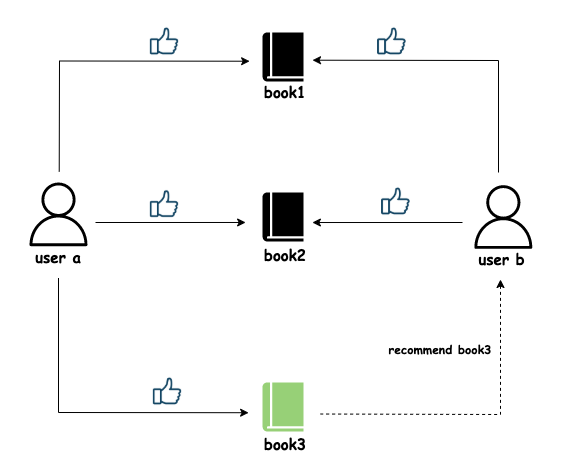

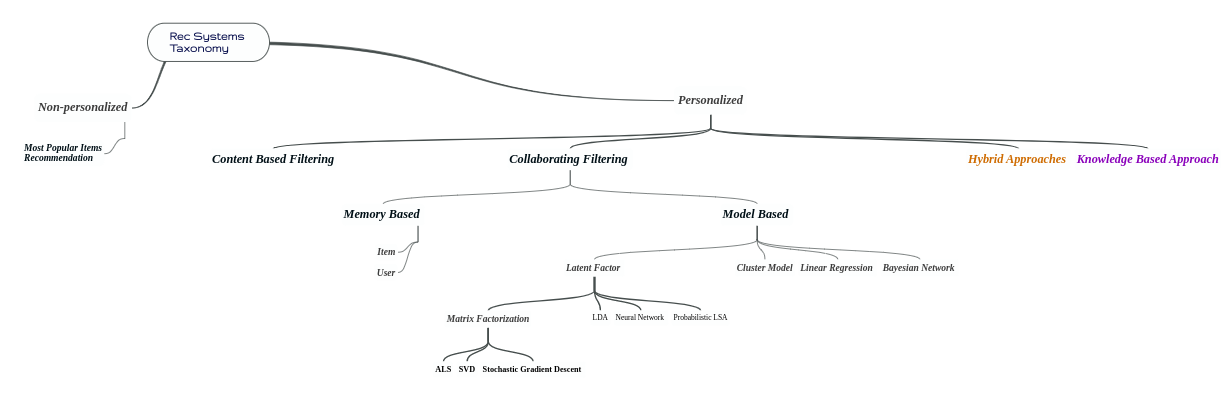

In [ ]:
# ALS model requires numeric user id and item id, make sure to convert them if they are not
als = ALS(
    maxIter=5,
    regParam=0.01,
    userCol="user",  # Adjust column name
    itemCol="item",  # Adjust column name
    ratingCol="rating",
    coldStartStrategy="drop",
    nonnegative=True
)

In [ ]:
# Define a grid of hyperparameters to test
paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [10, 20]) \
    .addGrid(als.maxIter, [10, 15]) \
    .addGrid(als.regParam, [0.1, 0.01]) \
    .build()

In [ ]:
# Define evaluator as RMSE
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

### Pipelining

In [ ]:
# List of stages in your pipeline. As of now, it's just ALS, but you can have more stages.
stages = [als]

In [ ]:
# Construct the pipeline
pipeline = Pipeline(stages=stages)

Pipelining is a fundamental concept in computing and data analysis that helps in managing and processing data more efficiently. The idea of pipelining can be applied in various contexts, such as in CPU design, data processing, and machine learning workflows.

**Why We Use Pipelining**

1. **Increased Throughput**: Pipelining allows multiple stages of a process to operate simultaneously. This means that while one piece of data is being processed in one stage, other data can be processed in other stages. This parallelism increases the overall throughput of the system.

2. **Efficiency**: By breaking down a process into smaller stages, each stage can be optimized for its specific task. This leads to more efficient processing.

3. **Modularity**: Pipelines are often modular, meaning that each stage can be developed, maintained, and updated independently. This modularity makes it easier to manage and update complex systems.

4. **Streamlined Data Flow**: In data analysis, pipelines help in the smooth flow of data from one operation to another, reducing the complexity of data handling and transformation.

5. **Error and Dependency Handling**: Pipelines can be designed to handle errors gracefully and manage dependencies between different stages, ensuring that the entire process is robust.

**One Stage Pipelining**

- **Simpler Process**: A pipeline with only one stage is essentially a linear process without parallel stages. This might be suitable for simple tasks where the benefits of parallel processing are not significant.

- **Potential Underutilization**: In contexts where data processing can be broken down into multiple, simultaneous tasks, having only one stage might lead to underutilization of resources and lower throughput.

- **Less Complexity**: A single-stage pipeline is easier to understand and maintain, which can be advantageous for straightforward tasks or when simplicity is a priority.

- **Limited Scalability**: With only one stage, the scalability of the process might be limited. As the volume or complexity of the data increases, a single-stage pipeline might not be able to handle the load as efficiently as a multi-stage pipeline.

We have only one stage because we use ALS process only, and there are no cateorical data.

### Training

In [ ]:
# Build cross-validation
cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)

In [ ]:
# Fit the pipeline to training data
cv_model = cv.fit(train)

In [ ]:
# Extract best model from the tuning exercise using ParamGridBuilder
best_model = cv_model.bestModel

### Testing

In [ ]:
# Make predictions
predictions = best_model.transform(test)

### Evaluation

In [ ]:
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 3.9384024965102014




```
Using ratings data only:
Before pipelining, it was 1.14 (Good)
After pipelining, it was 6.12  (Not Good)

Using all:
With pipelining: 3.93 (Good)
```



**RMSE (Root Mean Squared Error)** is a metric commonly used in regression problems to measure the accuracy of predicted values compared to actual values. While RMSE is more commonly associated with numerical predictions, it can be adapted for evaluating the performance of a recommendation system, especially in scenarios where predicted scores or ratings are involved. Here's how you might apply RMSE to book recommendations:

**1. Prediction Scores:**

In a recommendation system, each user is often assigned predicted scores or ratings for items (books, in this case) based on their preferences and behavior.
These predicted scores can be compared with the actual ratings or preferences given by users.

**2. Formulation of RMSE for Recommendations:**
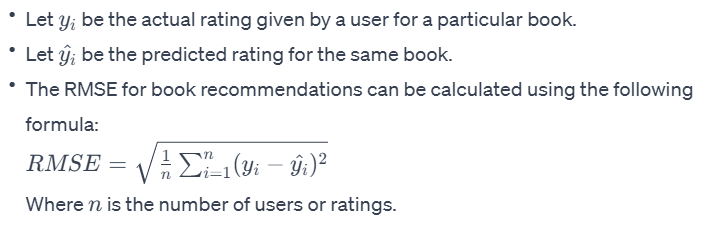

**3. Interpretation:**

A lower RMSE indicates that the predicted ratings are closer to the actual ratings, implying a more accurate recommendation system.
The interpretation is similar to traditional regression problems: the smaller the RMSE, the better the predictive accuracy.


## Top 10 Books  Recommendations For Each User

In [ ]:
# Generate top 10 book recommendations for each user
userRecs = best_model.stages[-1].recommendForAllUsers(10)  # stages[-1] to get the ALS model, which is last in the pipeline
userRecs.show()

+----+--------------------+
|user|     recommendations|
+----+--------------------+
|   9|[{886778204, 0.0}...|
|  12|[{385319290, 18.4...|
|  16|[{886778204, 0.0}...|
|  17|[{736413057, 12.5...|
|  19|[{198691793, 27.4...|
|  20|[{886778204, 0.0}...|
|  26|[{684135051, 16.8...|
|  44|[{198691793, 25.2...|
|  53|[{836218930, 21.2...|
|  78|[{375505008, 14.7...|
|  81|[{373270356, 15.7...|
|  85|[{886778204, 0.0}...|
|  86|[{525938400, 14.8...|
|  88|[{688171958, 13.6...|
|  91|[{385319290, 15.2...|
| 107|[{836218930, 16.9...|
| 132|[{886778204, 0.0}...|
| 133|[{373077882, 15.3...|
| 139|[{886778204, 0.0}...|
| 165|[{385319290, 31.9...|
+----+--------------------+
only showing top 20 rows



In [ ]:
# Convert the "recommendations" column to a string
df = userRecs.withColumn("recommendations", col("recommendations").cast("string"))

# Save Spark DataFrame to CSV
csv_file_path = "top1_data.csv"
df.write.csv(csv_file_path, header=True, mode="overwrite")
print(f"\nSpark DataFrame saved to CSV: {csv_file_path}")

# Collect Spark DataFrame to Pandas DataFrame
pandas_df = df.select("user", "recommendations").toPandas()

# Display Pandas DataFrame
print("\nPandas DataFrame:")
print(pandas_df)


Spark DataFrame saved to CSV: top1_data.csv

Pandas DataFrame:
         user                                    recommendations
0           9  [{1558596380, 0.0}, {1558581790, 0.0}, {155858...
1          12  [{385319290, 18.429703}, {962140406, 14.25357}...
2          16  [{1558596380, 0.0}, {1558581790, 0.0}, {155858...
3          17  [{736413057, 12.540316}, {1570820538, 12.51475...
4          19  [{198691793, 27.442158}, {803726236, 17.977007...
...       ...                                                ...
70877  278836  [{1570820538, 14.420936}, {736413057, 14.40577...
70878  278838  [{1558596380, 0.0}, {1558581790, 0.0}, {155858...
70879  278843  [{373270356, 26.25372}, {1570820538, 20.531599...
70880  278844  [{373270356, 12.290508}, {1558532854, 11.79382...
70881  278852  [{385319290, 20.352913}, {816748128, 11.379091...

[70882 rows x 2 columns]


## Top 10 Users Recommendations For Each Book

In [ ]:
# Similarly, recommend top 10 users for each book
bookRecs = best_model.stages[-1].recommendForAllItems(10)
bookRecs.show()

+-------+--------------------+
|   item|     recommendations|
+-------+--------------------+
| 913154|[{258717, 12.8782...|
|1046934|[{167196, 0.0}, {...|
|1047868|[{167196, 0.0}, {...|
|1047973|[{22045, 13.78997...|
|1048082|[{244627, 12.4869...|
|1048473|[{167196, 0.0}, {...|
|1049879|[{167196, 0.0}, {...|
|1232088|[{167196, 0.0}, {...|
|1372564|[{167196, 0.0}, {...|
|1374869|[{138649, 19.2282...|
|1382381|[{167196, 0.0}, {...|
|1382608|[{167196, 0.0}, {...|
|1711105|[{167196, 0.0}, {...|
|1714236|[{167196, 0.0}, {...|
|1714600|[{91164, 17.37621...|
|1811819|[{138176, 20.2836...|
|1837397|[{225495, 18.4618...|
|1841572|[{16827, 11.40745...|
|1845039|[{187761, 15.0245...|
|1846086|[{167196, 0.0}, {...|
+-------+--------------------+
only showing top 20 rows



In [ ]:
# Convert the "recommendations" column to a string
df = bookRecs.withColumn("recommendations", col("recommendations").cast("string"))

# Save Spark DataFrame to CSV
csv_file_path = "top2_data.csv"
df.write.csv(csv_file_path, header=True, mode="overwrite")
print(f"\nSpark DataFrame saved to CSV: {csv_file_path}")

# Collect Spark DataFrame to Pandas DataFrame
pandas_df = df.select("item", "recommendations").toPandas()

# Display Pandas DataFrame
print("\nPandas DataFrame:")
print(pandas_df)


Spark DataFrame saved to CSV: top2_data.csv

Pandas DataFrame:
              item                                    recommendations
0           913154  [{258717, 12.878204}, {243065, 12.276029}, {20...
1          1046934  [{249026, 0.0}, {249006, 0.0}, {248996, 0.0}, ...
2          1047213  [{244627, 13.708369}, {22045, 13.57173}, {5366...
3          1047868  [{249026, 0.0}, {249006, 0.0}, {248996, 0.0}, ...
4          1047973  [{22045, 13.78997}, {53663, 13.053383}, {24462...
...            ...                                                ...
201589  2130457193  [{178079, 12.0847845}, {227467, 11.340281}, {2...
201590  2130457622  [{249026, 0.0}, {249006, 0.0}, {248996, 0.0}, ...
201591  2130467784  [{249026, 0.0}, {249006, 0.0}, {248996, 0.0}, ...
201592  2130483410  [{249026, 0.0}, {249006, 0.0}, {248996, 0.0}, ...
201593  2130507395  [{249026, 0.0}, {249006, 0.0}, {248996, 0.0}, ...

[201594 rows x 2 columns]


## Saving the Model

In [ ]:
# Save the model for future use
best_model.stages[-1].write().overwrite().save("best_als_model")

## Loading the Model (if needed)

In [ ]:
# Load the model when needed
sameModel = ALSModel.load("best_als_model")

# Saved Information

https://drive.google.com/drive/folders/1_ekOpuCSUJjjJyZthC3A1WN0HzzMmCT_?usp=sharing

# Other Trials

## **Using K-means Model**

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
import  pyspark.sql.functions as fn

# importing the pipline
from pyspark.ml.pipeline import Pipeline
from pyspark.sql.functions import col, sum as spark_sum
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

spark=SparkSession.builder.getOrCreate()

In [ ]:
# Import the file locally after downloading it

books_df = spark.read.csv("Books.csv",header=True,inferSchema=True)
ratings_df = spark.read.csv("Ratings.csv",header=True,inferSchema=True)
users_df = spark.read.csv("Users.csv",header=True,inferSchema=True)
concatenated_df = books_df.join(ratings_df, on='ISBN', how='inner')
dataset_df = concatenated_df.join(users_df, on='User-ID', how='inner')

In [ ]:
# By using 'Year-Of-Publication' as the chosen feature
# Convert 'Year-Of-Publication' to numeric and handle null values if any
dataset_df = dataset_df.withColumn("Year-Of-Publication", dataset_df["Year-Of-Publication"].cast("int"))
dataset_df = dataset_df.fillna({'Year-Of-Publication': 0})  # Fill nulls with a default value

features = ["Year-Of-Publication"]

In [ ]:
# Vector Assembler to combine features into a single vector column
vector_assembler = VectorAssembler(inputCols=features, outputCol="features")

# Define the K-means model
num_clusters = 5
kmeans = KMeans().setK(num_clusters).setSeed(1)

# Create a pipeline with VectorAssembler and KMeans
pipeline = Pipeline(stages=[vector_assembler, kmeans])

# Fit the model on the dataset
model = pipeline.fit(dataset_df)

# Assign clusters to the data points
predictions = model.transform(dataset_df)

# Display the clustering result
predictions.select("ISBN", "Book-Title", "Book-Author", "Year-Of-Publication", "Book-Rating", "prediction").show()

+----------+--------------------+--------------------+-------------------+-----------+----------+
|      ISBN|          Book-Title|         Book-Author|Year-Of-Publication|Book-Rating|prediction|
+----------+--------------------+--------------------+-------------------+-----------+----------+
|0195153448| Classical Mythology|  Mark P. O. Morford|               2002|          0|         0|
|0002005018|        Clara Callan|Richard Bruce Wright|               2001|          5|         0|
|0060973129|Decision in Normandy|        Carlo D'Este|               1991|          0|         2|
|0374157065|Flu: The Story of...|    Gina Bari Kolata|               1999|          0|         3|
|0393045218|The Mummies of Ur...|     E. J. W. Barber|               1999|          0|         3|
|0399135782|The Kitchen God's...|             Amy Tan|               1991|          0|         2|
|0425176428|What If?: The Wor...|       Robert Cowley|               2000|          0|         0|
|0671870432|     PLE

In [ ]:
# Evaluate the clustering - Silhouette Score
# The Silhouette score  ranges from -1 to +1.
# A higher score indicates better-defined clusters,
# where values closer to +1 imply dense, well-separated clusters

from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette with squared euclidean distance = {silhouette}")

Silhouette with squared euclidean distance = 0.6992820004926092
